In [46]:
#!/usr/bin/env python
# coding: utf-8

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import load_model
from scipy.stats import mannwhitneyu


In [12]:


# Constants (adjust to match your training directory)
PARENT_DIR = ""
MODEL_DIR = "model"  # Matches your training code
DATA_DIR = "data"

def process_sentence(description):
    """Clean text by removing special characters, HTML tags, URLs, and converting to lowercase."""
    text = re.sub(r'<.*?>', '', description)  # Remove HTML tags
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'[\\\\/:*#&«`\'?¿";!<>(),.│0-9;=-]', '', text.lower().strip())  # Remove special chars
    return text

def convert_to_int(data, vocab_to_int):
    """Convert text data to integer sequences."""
    return [[vocab_to_int[word] if word in vocab_to_int else vocab_to_int["<UNK>"] 
             for word in sentence.split()] for sentence in data]

def load_test_data():
    """Load test dataset."""
    print("Loading test dataset...")
    df_test = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
    x_test, y_test = df_test['Description'], df_test['Class Index']
    print("Test dataset loaded.")
    return x_test, y_test

def load_artifacts():
    """Load saved preprocessing artifacts."""
    with open(os.path.join(MODEL_DIR, 'vocab_to_int.pkl'), 'rb') as f:
        vocab_to_int = pickle.load(f)
    with open(os.path.join(MODEL_DIR, 'onehot_encoder.pkl'), 'rb') as f:
        enc = pickle.load(f)
    with open(os.path.join(MODEL_DIR, 'max_sentence_length.pkl'), 'rb') as f:
        max_sentence_length = pickle.load(f)
    return vocab_to_int, enc, max_sentence_length

def prepare_test_data(x_test, y_test, vocab_to_int, enc, max_sentence_length):
    """Preprocess and prepare test data for evaluation."""
    x_test_proc = x_test.apply(process_sentence)
    X_test_encoded = convert_to_int(x_test_proc, vocab_to_int)
    X_test_pad = sequence.pad_sequences(X_test_encoded, maxlen=max_sentence_length)
    
    y_test_reshaped = np.array(y_test).reshape(-1, 1)
    y_test_encoded = enc.transform(y_test_reshaped).toarray()
    
    return X_test_pad, y_test_encoded


class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

def evaluate_model(model, X_test_pad, y_test_encoded, y_test):
    """Evaluate the model on test data and plot confusion matrix."""
    scores = model.evaluate(X_test_pad, y_test_encoded, verbose=1)
    print(f"Test Accuracy: {scores[1]*100:.2f}%")
    
    test_predict = model.predict(X_test_pad)
    y_pred = [np.argmax(i) + 1 for i in test_predict]
    
    
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(PARENT_DIR, "test_conf_matrix.jpg"), dpi=600)
    plt.show()
    
    return y_pred

def classify_text_file(file_path, model, vocab_to_int, max_sentence_length):
    """
    Classify the content of a text file and return the predicted class as string and number.
    
    Parameters:
    - file_path (str): Path to the text file to classify.
    - model: Loaded TensorFlow/Keras model.
    - vocab_to_int (dict): Vocabulary mapping words to integers.
    - max_sentence_length (int): Maximum sequence length for padding.
    
    Returns:
    - tuple: (class_string, class_number) where class_string is the predicted label (e.g., "World News")
             and class_number is the predicted class index (1-4).
    """
    # Define class labels (matching your training setup)
    class_labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']
    class_numbers = [1, 2, 3, 4]  # Corresponding to 'World', 'Sports', 'Business', 'Sci/Tech'

    # Read the text file
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None, None
    except Exception as e:
        print(f"Error reading file: {e}")
        return None, None

    # Process the text
    processed_text = process_sentence(text)
    
    # Convert to integer sequence
    encoded_text = convert_to_int([processed_text], vocab_to_int)
    
    # Pad the sequence
    padded_text = sequence.pad_sequences(encoded_text, maxlen=max_sentence_length)
    
    # Ensure model is built by calling it with a dummy input if needed
    if not model.built:
        dummy_input = tf.zeros((1, max_sentence_length), dtype=tf.int32)
        model(dummy_input)  # Build the model with the expected input shape
    
    # Predict using the model
    prediction = model.predict(padded_text, verbose=0)
    predicted_idx = np.argmax(prediction[0])
    
    # Get the class string and number
    class_string = class_labels[predicted_idx]
    class_number = class_numbers[predicted_idx]
    
    # Print and return the result
    print(f"Text File: {file_path}")
    print(f"Predicted Class: {class_string} (Number: {class_number})")
    return class_string, class_number

Loading trained model...
Model loaded.
Loading test dataset...
Test dataset loaded.
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8935 - loss: 0.3580
Test Accuracy: 89.63%
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
              precision    recall  f1-score   support

       World       0.93      0.89      0.91      1900
      Sports       0.94      0.97      0.95      1900
    Business       0.91      0.81      0.85      1900
    Sci/Tech       0.82      0.92      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



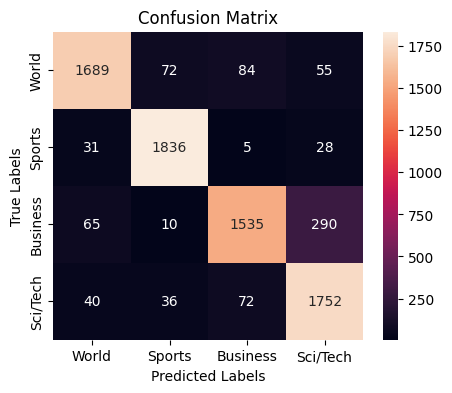

Predictions saved to test_predictions.csv


In [13]:
# Load preprocessing artifacts
vocab_to_int, enc, max_sentence_length = load_artifacts()

# Load the trained model
print("Loading trained model...")
model = load_model(os.path.join(MODEL_DIR, 'best_model.h5'))
print("Model loaded.")

# Ensure model is built with the correct input shape
if not model.built:
    dummy_input = tf.zeros((1, max_sentence_length), dtype=tf.int32)
    model(dummy_input)  # Build the model with the expected input shape
    print("Model built with input shape:", model.input_shape)

# Option 1: Evaluate on test data
x_test, y_test = load_test_data()
X_test_pad, y_test_encoded = prepare_test_data(x_test, y_test, vocab_to_int, enc, max_sentence_length)
y_pred = evaluate_model(model, X_test_pad, y_test_encoded, y_test)
pd.DataFrame({'True_Label': y_test, 'Predicted_Label': y_pred}).to_csv(
    os.path.join(DATA_DIR, 'test_predictions.csv'), index=False)
print("Predictions saved to test_predictions.csv")

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 956, 100)       │     8,658,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,677,898 (33.10 MB)

 Trainable params: 8,677,896 (33.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [15]:
layer_names = [layer.name for layer in model.layers[-2:-1]]
layer_names

['dense']

In [16]:
layer_index = -2  # Second-to-last layer (dense, 64 neurons)
layer_name = model.layers[layer_index].name
print(f"Analyzing layer: {layer_name}")

# Create a model that outputs the intermediate layer
# Instead of using model.input, use the layer's callable directly
intermediate_layer_output = model.get_layer(layer_name).output

# Define a function to compute activations
def get_activations(inputs):
    # Pass inputs through the full model up to the desired layer
    x = inputs
    for layer in model.layers[:layer_index + 1]:  # Up to and including the target layer
        x = layer(x)
    return x

# Plot activations
def plot_activations(activations, sample_idx=0):
    plt.figure(figsize=(12, 4))
    plt.bar(range(activations.shape[1]), activations[sample_idx], color='blue')
    plt.title(f"Activations of Layer {layer_name} for Sample {sample_idx}")
    plt.xlabel("Neuron Index")
    plt.ylabel("Activation Value")
    plt.savefig(os.path.join(PARENT_DIR, f"layer_activations_sample_{sample_idx}.jpg"))
    plt.show()
    
# Get activations for 10 samples
inputs = tf.convert_to_tensor(X_test_pad[:])  # Shape (10, 956)
activations = get_activations(inputs)
activations = activations.numpy()  # Convert to NumPy array
print(f"Activations shape: {activations.shape}")  # Should be (10, 64)

Analyzing layer: dense
Activations shape: (7600, 64)


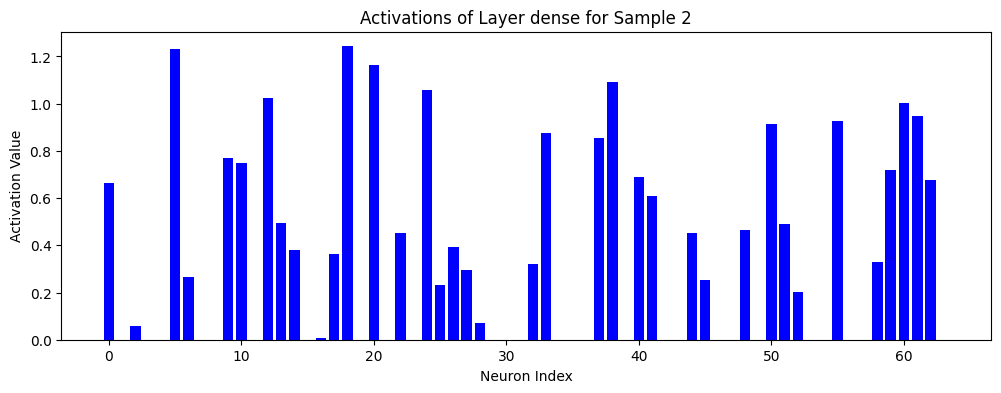

In [17]:
plot_activations(activations, sample_idx=2)

#### Compute Max Activation per Neuron

In [19]:
all_activations = get_activations(tf.convert_to_tensor(X_test_pad)).numpy()  # Shape: (7600, 64)
max_activations = np.max(all_activations, axis=0)  # Shape: (64,)

In [20]:
all_activations.shape, max_activations.shape

((7600, 64), (64,))

#### Creating a dataframe with all the activation values

In [21]:
df = pd.DataFrame({'Original_Text': x_test})

# Columns 2-65: Neuron activations (named Neuron_0 to Neuron_63)
for neuron in range(64):
    df[f'Neuron_{neuron}'] = all_activations[:, neuron]

# Column 66: Class values as strings
# y_test is numeric (1-4), map to class_names
class_map = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tech'}
df['Class_String'] = [class_map[y] for y in y_test]

# Column 67: Class values as numbers (use y_test)
df['Class_Number'] = y_test

# Display the first few rows
print("DataFrame head:")
display(df.head())

# Save the DataFrame
output_path = os.path.join(PARENT_DIR, 'neuron_activations_with_labels.csv')
df.to_csv(output_path, index=False)
print(f"DataFrame saved to {output_path}")

DataFrame head:


,Original_Text,Neuron_0,Neuron_1,Neuron_2,Neuron_3,Neuron_4,Neuron_5,Neuron_6,Neuron_7,Neuron_8,...,Neuron_56,Neuron_57,Neuron_58,Neuron_59,Neuron_60,Neuron_61,Neuron_62,Neuron_63,Class_String,Class_Number
0,Unions representing workers at Turner Newall...,0.844389,0.132179,0.000000,0.202501,0.178496,1.233700,0.000000,0.846505,0.476485,...,0.605004,0.726635,0.495511,0.410930,0.652345,0.161138,0.761121,0.100359,Business,3
1,"SPACE.com - TORONTO, Canada -- A second\team o...",0.969845,0.000000,0.000000,0.000000,0.000000,1.684551,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.491029,0.497704,1.425699,1.083047,0.926024,0.000000,Sci/Tech,4
2,AP - A company founded by a chemistry research...,0.662159,0.000000,0.056950,0.000000,0.000000,1.229996,0.264840,0.000000,0.000000,...,0.000000,0.000000,0.331146,0.720419,1.003112,0.949069,0.678218,0.000000,Sci/Tech,4
3,AP - It's barely dawn when Mike Fitzpatrick st...,0.153950,0.189388,0.520815,0.000000,0.403823,0.320329,0.659492,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.833176,0.304727,0.649445,0.161013,0.000000,Sci/Tech,4
4,AP - Southern California's smog-fighting agenc...,0.407467,0.236343,0.254358,0.022691,0.482228,0.567236,0.246939,0.000000,0.000000,...,0.000000,0.000000,0.136957,0.895659,0.353831,0.533916,0.399289,0.026402,Sci/Tech,4


DataFrame saved to neuron_activations_with_labels.csv


#### Positive Negative Set Generation

In [22]:
df_n = pd.DataFrame({'Original_Text': x_test})

# Columns 2-65: Neuron activations (named Neuron_0 to Neuron_63)

# Add positive/negative set columns
for neuron in range(64):
    # Get the activation column
    activations = df[f'Neuron_{neuron}']
    max_act = max_activations[neuron]
    
    # Define thresholds
    pos_threshold = 0.8 * max_act
    neg_threshold = 0.2 * max_act
    
    # Create a new column with 1 (positive), 0 (negative), or NaN (in between)
    df_n[f'PosNeg_Neuron_{neuron}'] = np.where(activations >= pos_threshold, 1,
                                            np.where(activations <= neg_threshold, 0, np.nan))

# Column 66: Class values as strings
# y_test is numeric (1-4), map to class_names
class_map = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tech'}
df_n['Class_String'] = [class_map[y] for y in y_test]

# Column 67: Class values as numbers (直接 use y_test)
df_n['Class_Number'] = y_test

# Display the first few rows
print("DataFrame head:")
display(df_n.head())

# Save the DataFrame
output_path = os.path.join(PARENT_DIR, 'neuron_activations_with_labels_and_posneg.csv')
df_n.to_csv(output_path, index=False)
print(f"DataFrame saved to {output_path}")

DataFrame head:


,Original_Text,PosNeg_Neuron_0,PosNeg_Neuron_1,PosNeg_Neuron_2,PosNeg_Neuron_3,PosNeg_Neuron_4,PosNeg_Neuron_5,PosNeg_Neuron_6,PosNeg_Neuron_7,PosNeg_Neuron_8,...,PosNeg_Neuron_56,PosNeg_Neuron_57,PosNeg_Neuron_58,PosNeg_Neuron_59,PosNeg_Neuron_60,PosNeg_Neuron_61,PosNeg_Neuron_62,PosNeg_Neuron_63,Class_String,Class_Number
0,Unions representing workers at Turner Newall...,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,Business,3
1,"SPACE.com - TORONTO, Canada -- A second\team o...",NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,1.0,1.0,NaN,0.0,Sci/Tech,4
2,AP - A company founded by a chemistry research...,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,Sci/Tech,4
3,AP - It's barely dawn when Mike Fitzpatrick st...,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,Sci/Tech,4
4,AP - Southern California's smog-fighting agenc...,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,Sci/Tech,4


DataFrame saved to neuron_activations_with_labels_and_posneg.csv


#### with Wordnet

In [23]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet as wn
from IPython.display import display

# Download WordNet if not already installed
import nltk
nltk.download('wordnet')

# Assuming df_n, x_test, y_test, PARENT_DIR are defined from previous steps

# Function to get top TF-IDF terms
def get_top_terms(texts, n=5, max_features=1000):
    vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    scores = tfidf_matrix.mean(axis=0).A1
    top_indices = scores.argsort()[-n:][::-1]
    return [feature_names[i] for i in top_indices]

# Function to map terms to WordNet synsets and get concepts
def get_wordnet_concepts(terms, neg_terms_set, max_concepts=3):
    concepts = []
    for term in terms:
        # Get synsets for the term (nouns only, common for news)
        synsets = wn.synsets(term, pos=wn.NOUN)
        if not synsets:
            continue
        # Take the first synset (most common sense) and its hypernyms
        synset = synsets[0]
        hypernyms = synset.hypernyms()
        candidate = synset.name()  # e.g., "game.n.01"
        # Check if the term or concept is rare in negative set
        if term not in neg_terms_set and len(concepts) < max_concepts:
            concepts.append(candidate)
        # Add a hypernym if it’s distinct and not too generic
        if hypernyms and hypernyms[0].name() not in ['entity.n.01', 'abstraction.n.01'] and len(concepts) < max_concepts:
            concepts.append(hypernyms[0].name())
    return concepts[:max_concepts]

# Generate label hypotheses for each neuron
label_hypotheses = {}
print("Generating label hypotheses with WordNet for each neuron...")
for neuron in range(64):
    # Extract positive and negative texts
    pos_texts = df_n[df_n[f'PosNeg_Neuron_{neuron}'] == 1]['Original_Text'].tolist()
    neg_texts = df_n[df_n[f'PosNeg_Neuron_{neuron}'] == 0]['Original_Text'].tolist()
    
    # Skip if either set is empty
    if not pos_texts or not neg_texts:
        print(f"Neuron {neuron}: Skipping (empty positive or negative set)")
        label_hypotheses[neuron] = []
        continue
    
    # Get top terms from positive set
    pos_terms = get_top_terms(pos_texts, n=5)
    
    # Get terms from negative set for filtering
    neg_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    neg_tfidf = neg_vectorizer.fit_transform(neg_texts)
    neg_terms_set = set(neg_vectorizer.get_feature_names_out())
    
    # Map to WordNet concepts
    candidate_labels = get_wordnet_concepts(pos_terms, neg_terms_set, max_concepts=3)
    label_hypotheses[neuron] = candidate_labels
    print(f"Neuron {neuron}: Candidate labels = {candidate_labels}")

# Save hypotheses to a file
hypotheses_df = pd.DataFrame({
    'Neuron': [f'Neuron_{i}' for i in range(64)],
    'Candidate_Labels': [', '.join(labels) if labels else 'None' for labels in label_hypotheses.values()]
})
output_path = os.path.join(PARENT_DIR, 'neuron_label_hypotheses_wordnet.csv')
hypotheses_df.to_csv(output_path, index=False)
print(f"Label hypotheses saved to {output_path}")
display(hypotheses_df.head())

[nltk_data] Downloading package wordnet to /Users/avishek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Generating label hypotheses with WordNet for each neuron...
Neuron 0: Candidate labels = []
Neuron 1: Candidate labels = ['iraq.n.01', 'gaza_strip.n.01', 'baghdad.n.01']
Neuron 2: Candidate labels = ['time_period.n.01', 'league.n.01', 'association.n.01']
Neuron 3: Candidate labels = ['iraq.n.01', 'gaza_strip.n.01', 'baghdad.n.01']
Neuron 4: Candidate labels = ['iraq.n.01', 'gaza_strip.n.01', 'baghdad.n.01']
Neuron 5: Candidate labels = ['company.n.01', 'institution.n.01', 'corporation.n.01']
Neuron 6: Candidate labels = ['league.n.01', 'association.n.01', 'activity.n.01']
Neuron 7: Candidate labels = ['oil.n.01', 'lipid.n.01']
Neuron 8: Candidate labels = ['stocks.n.01', 'framework.n.03']
Neuron 9: Candidate labels = []
Neuron 10: Candidate labels = ['company.n.01', 'institution.n.01']
Neuron 11: Candidate labels = ['freestyle.n.01', 'race.n.02', 'thorpe.n.01']
Neuron 12: Candidate labels = ['game.n.01', 'activity.n.01', 'time_period.n.01']
Neuron 13: Candidate labels = ['time_period.n

,Neuron,Candidate_Labels
0,Neuron_0,None
1,Neuron_1,"iraq.n.01, gaza_strip.n.01, baghdad.n.01"
2,Neuron_2,"time_period.n.01, league.n.01, association.n.01"
3,Neuron_3,"iraq.n.01, gaza_strip.n.01, baghdad.n.01"
4,Neuron_4,"iraq.n.01, gaza_strip.n.01, baghdad.n.01"


### Check validity of Wordnet Labels

In [26]:
hypotheses_df = pd.read_csv(os.path.join(PARENT_DIR,"neuron_label_hypotheses_wordnet.csv"))
display(hypotheses_df.head())


df_n = pd.read_csv(os.path.join(PARENT_DIR,"neuron_activations_with_labels_and_posneg.csv"))
df_n.head()

,Neuron,Candidate_Labels
0,Neuron_0,NaN
1,Neuron_1,"iraq.n.01, gaza_strip.n.01, baghdad.n.01"
2,Neuron_2,"time_period.n.01, league.n.01, association.n.01"
3,Neuron_3,"iraq.n.01, gaza_strip.n.01, baghdad.n.01"
4,Neuron_4,"iraq.n.01, gaza_strip.n.01, baghdad.n.01"


,Original_Text,PosNeg_Neuron_0,PosNeg_Neuron_1,PosNeg_Neuron_2,PosNeg_Neuron_3,PosNeg_Neuron_4,PosNeg_Neuron_5,PosNeg_Neuron_6,PosNeg_Neuron_7,PosNeg_Neuron_8,...,PosNeg_Neuron_56,PosNeg_Neuron_57,PosNeg_Neuron_58,PosNeg_Neuron_59,PosNeg_Neuron_60,PosNeg_Neuron_61,PosNeg_Neuron_62,PosNeg_Neuron_63,Class_String,Class_Number
0,Unions representing workers at Turner Newall...,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,Business,3
1,"SPACE.com - TORONTO, Canada -- A second\team o...",NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,1.0,1.0,NaN,0.0,Sci/Tech,4
2,AP - A company founded by a chemistry research...,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,Sci/Tech,4
3,AP - It's barely dawn when Mike Fitzpatrick st...,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,Sci/Tech,4
4,AP - Southern California's smog-fighting agenc...,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,Sci/Tech,4


In [46]:
neuron_1_pos_sets = df_n[df_n['PosNeg_Neuron_1']==1.0]['Original_Text']
neuron_1_labels = x.split()hypotheses_df[hypotheses_df['Neuron']=='Neuron_1'].values[0][1].split()

['iraq.n.01,', 'gaza_strip.n.01,', 'baghdad.n.01']

In [27]:
import pandas as pd
from nltk.corpus import wordnet as wn
from IPython.display import display

# Load the CSVs
hypotheses_df = pd.read_csv(os.path.join(PARENT_DIR, 'neuron_label_hypotheses_wordnet.csv'))
df_n = pd.read_csv(os.path.join(PARENT_DIR, 'neuron_activations_with_labels_and_posneg.csv'))

# Function to clean WordNet synset names into base terms
def clean_synset_name(synset_name):
    # e.g., 'iraq.n.01' -> 'iraq', 'gaza_strip.n.01' -> 'gaza strip'
    return synset_name.split('.')[0].replace('_', ' ')

# Function to get synonyms from WordNet for a term
def get_synonyms(term):
    synonyms = set([term])
    synsets = wn.synsets(term, pos=wn.NOUN)
    for synset in synsets:
        for lemma in synset.lemmas():
            synonyms.add(lemma.name().replace('_', ' '))
    return synonyms

# Semantic matching for Neuron 1
print("Validating Neuron 1 labels against positive set...")
neuron_1_pos_sets = df_n[df_n['PosNeg_Neuron_1'] == 1.0]['Original_Text'].tolist()
neuron_1_labels_raw = hypotheses_df[hypotheses_df['Neuron'] == 'Neuron_1']['Candidate_Labels'].values[0]

# Handle case where no labels exist
if neuron_1_labels_raw == 'None' or not neuron_1_labels_raw:
    print("Neuron 1: No labels to validate.")
else:
    # Clean and split labels
    neuron_1_labels = [clean_synset_name(label) for label in neuron_1_labels_raw.split(', ')]
    print(f"Neuron 1 labels: {neuron_1_labels}")

    # Get synonyms for each label
    label_synonyms = {label: get_synonyms(label) for label in neuron_1_labels}
    print(f"Neuron 1 label synonyms: {label_synonyms}")

    # Check semantic presence in positive set
    matches = 0
    for text in neuron_1_pos_sets:
        text_lower = text.lower()
        # Check if any label or its synonyms appear in the text
        for label, synonyms in label_synonyms.items():
            if any(synonym in text_lower for synonym in synonyms):
                matches += 1
                break  # Move to next text if any match found
    
    # Calculate match percentage
    total_pos_texts = len(neuron_1_pos_sets)
    match_pct = (matches / total_pos_texts * 100) if total_pos_texts > 0 else 0
    print(f"Neuron 1: {matches} out of {total_pos_texts} positive texts contain a label-related term ({match_pct:.2f}%)")
    print(f"Sample positive texts: {neuron_1_pos_sets[:3]}")  # Show a few examples

# Optional: Save results
validation_result = {
    'Neuron': 'Neuron_1',
    'Candidate_Labels': neuron_1_labels_raw,
    'Positive_Set_Size': total_pos_texts,
    'Matches': matches,
    'Match_Percentage': match_pct
}
validation_df = pd.DataFrame([validation_result])
output_path = os.path.join(PARENT_DIR, 'neuron_1_semantic_validation.csv')
validation_df.to_csv(output_path, index=False)
print(f"Validation result saved to {output_path}")
display(validation_df)

Validating Neuron 1 labels against positive set...
Neuron 1 labels: ['iraq', 'gaza strip', 'baghdad']
Neuron 1 label synonyms: {'iraq': {'Republic of Iraq', 'Al-Iraq', 'iraq', 'Irak', 'Iraq'}, 'gaza strip': {'gaza strip'}, 'baghdad': {'Bagdad', 'Baghdad', 'capital of Iraq', 'baghdad'}}
Neuron 1: 78 out of 230 positive texts contain a label-related term (33.91%)
Sample positive texts: ["BAGHDAD, Iraq - Delegates at Iraq's National Conference called on radical Shiite cleric Muqtada al-Sadr to abandon his uprising against U.S. and Iraqi troops and pull his fighters out of a holy shrine in Najaf...", 'AFP - Sudan will take the lead in restoring order to its rebellious Darfur region but needs the support of African peacekeepers and humanitarian aid, Foreign Minister Mustafa Osman Ismail said.', 'A CANADIAN husband #39;s love for his wife has led to a tightening of security at all Olympic venues in Athens. ']
Validation result saved to neuron_1_semantic_validation.csv


,Neuron,Candidate_Labels,Positive_Set_Size,Matches,Match_Percentage
0,Neuron_1,"iraq.n.01, gaza_strip.n.01, baghdad.n.01",230,78,33.913043


#### maching percentage for all neurons

In [6]:
import pandas as pd
from nltk.corpus import wordnet as wn
from IPython.display import display
import numpy as np

# Load the CSVs
hypotheses_df = pd.read_csv(os.path.join(PARENT_DIR, 'neuron_label_hypotheses_wordnet.csv'))
df_n = pd.read_csv(os.path.join(PARENT_DIR, 'neuron_activations_with_labels_and_posneg.csv'))

# Function to clean WordNet synset names into base terms
def clean_synset_name(synset_name):
    return synset_name.split('.')[0].replace('_', ' ')

# Function to get synonyms from WordNet for a term
def get_synonyms(term):
    synonyms = set([term])
    synsets = wn.synsets(term, pos=wn.NOUN)
    for synset in synsets:
        for lemma in synset.lemmas():
            synonyms.add(lemma.name().replace('_', ' '))
    return synonyms

# Semantic validation for all neurons
validation_results = []
print("Validating labels against positive sets for all neurons...")
for neuron in range(64):
    # Extract positive set for the neuron
    pos_sets = df_n[df_n[f'PosNeg_Neuron_{neuron}'] == 1.0]['Original_Text'].tolist()
    total_pos_texts = len(pos_sets)
    
    # Get labels for the neuron
    neuron_labels_raw = hypotheses_df[hypotheses_df['Neuron'] == f'Neuron_{neuron}']['Candidate_Labels'].values[0]
    
    # Check if labels are valid (string and not NaN or 'None')
    if not isinstance(neuron_labels_raw, str) or neuron_labels_raw == 'None' or pd.isna(neuron_labels_raw):
        print(f"Neuron {neuron}: No valid labels or positive set to validate.")
        validation_results.append({
            'Neuron': f'Neuron_{neuron}',
            'Candidate_Labels': str(neuron_labels_raw),  # Convert to string for consistency
            'Positive_Set_Size': total_pos_texts,
            'Matches': 0,
            'Match_Percentage': 0.0
        })
        continue
    
    # Clean and split labels
    neuron_labels = [clean_synset_name(label) for label in neuron_labels_raw.split(', ')]
    print(f"Neuron {neuron} labels: {neuron_labels}")
    
    # Get synonyms for each label
    label_synonyms = {label: get_synonyms(label) for label in neuron_labels}
    #print(f"Neuron {neuron} label synonyms: {label_synonyms}")
    
    # Check semantic presence in positive set
    matches = 0
    for text in pos_sets:
        text_lower = text.lower()
        for label, synonyms in label_synonyms.items():
            if any(synonym in text_lower for synonym in synonyms):
                matches += 1
                break  # Move to next text if any match found
    
    # Calculate match percentage
    match_pct = (matches / total_pos_texts * 100) if total_pos_texts > 0 else 0
    print(f"Neuron {neuron}: {matches} out of {total_pos_texts} positive texts contain a label-related term ({match_pct:.2f}%)")
    
    # Store result
    validation_results.append({
        'Neuron': f'Neuron_{neuron}',
        'Candidate_Labels': neuron_labels_raw,
        'Positive_Set_Size': total_pos_texts,
        'Matches': matches,
        'Match_Percentage': match_pct
    })

# Create and save DataFrame
validation_df = pd.DataFrame(validation_results)
output_path = os.path.join(PARENT_DIR, 'neuron_semantic_validation_all.csv')
validation_df.to_csv(output_path, index=False)
print(f"Validation results saved to {output_path}")
display(validation_df.head())

Validating labels against positive sets for all neurons...
Neuron 0: No valid labels or positive set to validate.
Neuron 1 labels: ['iraq', 'gaza strip', 'baghdad']
Neuron 1: 78 out of 230 positive texts contain a label-related term (33.91%)
Neuron 2 labels: ['time period', 'league', 'association']
Neuron 2: 73 out of 368 positive texts contain a label-related term (19.84%)
Neuron 3 labels: ['iraq', 'gaza strip', 'baghdad']
Neuron 3: 97 out of 229 positive texts contain a label-related term (42.36%)
Neuron 4 labels: ['iraq', 'gaza strip', 'baghdad']
Neuron 4: 108 out of 349 positive texts contain a label-related term (30.95%)
Neuron 5 labels: ['company', 'institution', 'corporation']
Neuron 5: 430 out of 1157 positive texts contain a label-related term (37.17%)
Neuron 6 labels: ['league', 'association', 'activity']
Neuron 6: 55 out of 252 positive texts contain a label-related term (21.83%)
Neuron 7 labels: ['oil', 'lipid']
Neuron 7: 105 out of 414 positive texts contain a label-relate

,Neuron,Candidate_Labels,Positive_Set_Size,Matches,Match_Percentage
0,Neuron_0,nan,141,0,0.000000
1,Neuron_1,"iraq.n.01, gaza_strip.n.01, baghdad.n.01",230,78,33.913043
2,Neuron_2,"time_period.n.01, league.n.01, association.n.01",368,73,19.836957
3,Neuron_3,"iraq.n.01, gaza_strip.n.01, baghdad.n.01",229,97,42.358079
4,Neuron_4,"iraq.n.01, gaza_strip.n.01, baghdad.n.01",349,108,30.945559


## Get Pos-Neg Set Texts for Each Neuron

In [29]:
PARENT_DIR = ""  

pos_neg_df = pd.read_csv(os.path.join(PARENT_DIR,"neuron_activations_with_labels_and_posneg.csv"))
pos_neg_df.head()

neuron_activation_df = pd.read_csv(os.path.join(PARENT_DIR, "neuron_activations_with_labels.csv"))
neuron_activation_df.head()

,Original_Text,Neuron_0,Neuron_1,Neuron_2,Neuron_3,Neuron_4,Neuron_5,Neuron_6,Neuron_7,Neuron_8,...,Neuron_56,Neuron_57,Neuron_58,Neuron_59,Neuron_60,Neuron_61,Neuron_62,Neuron_63,Class_String,Class_Number
0,Unions representing workers at Turner Newall...,0.844389,0.132179,0.000000,0.202501,0.178496,1.233700,0.000000,0.846505,0.476485,...,0.605004,0.726635,0.495511,0.410930,0.652345,0.161138,0.761121,0.100359,Business,3
1,"SPACE.com - TORONTO, Canada -- A second\team o...",0.969846,0.000000,0.000000,0.000000,0.000000,1.684551,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.491029,0.497704,1.425698,1.083047,0.926024,0.000000,Sci/Tech,4
2,AP - A company founded by a chemistry research...,0.662159,0.000000,0.056950,0.000000,0.000000,1.229996,0.264840,0.000000,0.000000,...,0.000000,0.000000,0.331146,0.720419,1.003112,0.949069,0.678218,0.000000,Sci/Tech,4
3,AP - It's barely dawn when Mike Fitzpatrick st...,0.153950,0.189388,0.520815,0.000000,0.403824,0.320329,0.659492,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.833176,0.304727,0.649445,0.161013,0.000000,Sci/Tech,4
4,AP - Southern California's smog-fighting agenc...,0.407467,0.236343,0.254358,0.022691,0.482228,0.567236,0.246939,0.000000,0.000000,...,0.000000,0.000000,0.136957,0.895659,0.353831,0.533915,0.399289,0.026402,Sci/Tech,4


In [30]:
pos_neg_df[pos_neg_df['PosNeg_Neuron_0'] == 0.0][['Original_Text', 'Class_String']]

,Original_Text,Class_String
3,AP - It's barely dawn when Mike Fitzpatrick st...,Sci/Tech
26,Michael Phelps won the gold medal in the 400 i...,Sports
27,FOXBOROUGH -- Looking at his ridiculously deve...,Sports
28,With the weeks dwindling until Jason Varitek e...,Sports
29,Just imagine what David Ortiz could do on a go...,Sports
...,...,...
7593,Paceman Mashrafe Mortaza claimed two prize sca...,Sports
7594,WASHINGTON -- Outgoing Secretary of State Coli...,World
7595,Ukrainian presidential candidate Viktor Yushch...,World
7596,With the supply of attractive pitching options...,Sports


In [31]:
pos_neg_df[pos_neg_df['PosNeg_Neuron_0'] == 1.0][['Original_Text', 'Class_String']]

,Original_Text,Class_String
161,USATODAY.com - The Securities and Exchange Com...,Business
180,"NEW YORK (Reuters) - Kroger Co., the top U.S....",Business
207,"Reuters - Intuit Inc. (INTU.O), maker of\the N...",Sci/Tech
216,Health care and consumer products maker Johnso...,Business
346,Software developer Salesforce.com Inc. posted ...,Sci/Tech
...,...,...
7294,"PeopleSoft Inc. capitulated to Oracle Corp., a...",Business
7400,Sprint Corp. and Nextel Communications Inc. on...,Business
7422,Gateway Inc. on Wednesday raised fourth-quarte...,Business
7456,Apple Computer Inc. #39;s iPod digital music p...,Sci/Tech


In [32]:
import os
import pandas as pd

output_dir = os.path.join(PARENT_DIR, "pos_neg_text")

# Ensure output directory exists
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

for i in range(64):
    neuron = "PosNeg_Neuron_" + str(i)
    
    # Filter positive and negative examples
    neg = pos_neg_df[pos_neg_df[neuron] == 0.0][['Original_Text', 'Class_String', 'Class_Number']]
    pos = pos_neg_df[pos_neg_df[neuron] == 1.0][['Original_Text', 'Class_String', 'Class_Number']]
    
    # Add Neuron_i values from neuron_activation_df for positive examples
    if not pos.empty:
        neuron_col = f"Neuron_{i}"
        # Ensure indices exist in neuron_activation_df
        pos_valid_indices = pos.index[pos.index.isin(neuron_activation_df.index)]
        if not pos_valid_indices.empty:
            pos.loc[pos_valid_indices, neuron_col] = neuron_activation_df.loc[pos_valid_indices, neuron_col]

        neg_valid_indices = neg.index[neg.index.isin(neuron_activation_df.index)]
        if not neg_valid_indices.empty:
            neg.loc[neg_valid_indices, neuron_col] = neuron_activation_df.loc[neg_valid_indices, neuron_col]
            
    
    # Define filenames
    pos_filename = f"Neuron_{i}_pos.csv"
    neg_filename = f"Neuron_{i}_neg.csv"
    
    # Save to CSV
    pos.to_csv(os.path.join(output_dir, pos_filename))
    neg.to_csv(os.path.join(output_dir, neg_filename))

In [33]:
pos

,Original_Text,Class_String,Class_Number,Neuron_63
57,"BAGHDAD, Iraq - Delegates at Iraq's National C...",World,1,0.923090
90,KABUL (Reuters) - The United States has broke...,World,1,0.874815
108,AFP - Sudan will take the lead in restoring or...,World,1,0.922976
159,GAZA (Reuters) - A senior Hamas leader surviv...,World,1,0.837558
192,AFP - Democratic White House hopeful Senator J...,World,1,0.847874
...,...,...,...,...
7396,"ANKARA, Dec 15 (AFP) - The Turkish ambassador ...",World,1,0.871254
7419,AFP - An Italian national working for a Britis...,World,1,0.865376
7534,BAGHDAD (AFP) - The United States failed win a...,World,1,0.862505
7560,JERUSALEM (Reuters) - Israel's opposition Lab...,World,1,0.846730


In [34]:
neuron_activation_df.loc[pos.index, 'Neuron_63']

57      0.923090
90      0.874815
108     0.922976
159     0.837558
192     0.847874
          ...   
7396    0.871254
7419    0.865376
7534    0.862505
7560    0.846730
7578    0.849549
Name: Neuron_63, Length: 205, dtype: float64

In [35]:
from collections import Counter

Counter(pos_neg_df[pos_neg_df['PosNeg_Neuron_0'] == 1.0]['Class_String'])

Counter({'Business': 128, 'Sci/Tech': 12, 'World': 1})

In [36]:
Counter(pos_neg_df[pos_neg_df['PosNeg_Neuron_0'] == 0.0]['Class_String'])

Counter({'Sports': 1856, 'World': 1495, 'Sci/Tech': 47, 'Business': 26})

## Concept Validation

In [39]:
# GET TEST DATA ACTIVATION

vocab_to_int, enc, max_sentence_length = load_artifacts()

def get_testData_activation(df, neuron_number):
    x_test = df['Original_Text']
    y_test = df['Class_Number']
    
    X_test_pad, y_test_encoded = prepare_test_data(x_test, y_test, vocab_to_int, enc, max_sentence_length)
    all_activations = get_activations(tf.convert_to_tensor(X_test_pad)).numpy()  # Shape: (7600, 64)
    max_activations = np.max(all_activations, axis=0)  # Shape: (64,)
    
    df = pd.DataFrame({'Original_Text': x_test})
    
    df[f'Neuron_{neuron_number}'] = all_activations[:, neuron_number]
    
    class_map = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tech'}
    df['Class_String'] = [class_map[y] for y in y_test]

    df['Class_Number'] = y_test

    return df

### Stage 1

In [42]:
from tqdm import tqdm

DATA_DIR_ST_1 = os.path.join(DATA_DIR, "new_test_data_stage_1/")

with open("test_activation_report_stage_1.csv", 'a') as r:
    r.write("Neuron,pos_above_80,neg_above_80,threshold_80_pos,threshold_80_neg\n")
    for neuron_num in tqdm(range(64)):
        pos_file = f"{DATA_DIR_ST_1}test_Neuron_{neuron_num}_pos.csv"
        neg_file = f"{DATA_DIR_ST_1}test_Neuron_{neuron_num}_neg.csv"
    
        try:
            df_pos = pd.read_csv(pos_file)
            df_neg = pd.read_csv(neg_file)
            
            pos_act = get_testData_activation(df_pos, neuron_num)
            neg_act = get_testData_activation(df_neg, neuron_num)

            pos_act.to_csv(pos_file, index=False)
            neg_act.to_csv(neg_file, index=False)
                        
            thresh_80_pos = max(pos_act[f"Neuron_{neuron_num}"])*0.8
            thresh_80_neg = max(neg_act[f"Neuron_{neuron_num}"])*0.8
            
            above_thresh_80_pos = len(pos_act[f"Neuron_{neuron_num}"][pos_act[f"Neuron_{neuron_num}"].apply(lambda x: x>thresh_80_pos)])
            above_thresh_80_neg = len(neg_act[f"Neuron_{neuron_num}"][neg_act[f"Neuron_{neuron_num}"].apply(lambda x: x>thresh_80_neg)])

            r.write(f"{neuron_num},{above_thresh_80_pos},{above_thresh_80_neg},{thresh_80_pos},{thresh_80_neg}\n")
        except Exception as e:
            print(e)
            # print(f"{pos_file} Does not Exist")
            # print(f"{neg_file} Does not Exist")

  5%|██                                          | 3/64 [00:00<00:02, 23.12it/s]

[Errno 2] No such file or directory: 'data/new_test_data_stage_1/test_Neuron_0_pos.csv'


 20%|████████▋                                  | 13/64 [00:00<00:02, 24.50it/s]

[Errno 2] No such file or directory: 'data/new_test_data_stage_1/test_Neuron_9_pos.csv'


 31%|█████████████▍                             | 20/64 [00:00<00:01, 26.82it/s]

[Errno 2] No such file or directory: 'data/new_test_data_stage_1/test_Neuron_16_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_1/test_Neuron_20_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_1/test_Neuron_22_pos.csv'


 48%|████████████████████▊                      | 31/64 [00:01<00:00, 37.32it/s]

[Errno 2] No such file or directory: 'data/new_test_data_stage_1/test_Neuron_26_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_1/test_Neuron_27_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_1/test_Neuron_29_pos.csv'


 78%|█████████████████████████████████▌         | 50/64 [00:01<00:00, 28.79it/s]

[Errno 2] No such file or directory: 'data/new_test_data_stage_1/test_Neuron_44_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_1/test_Neuron_47_pos.csv'


 95%|████████████████████████████████████████▉  | 61/64 [00:02<00:00, 27.91it/s]

[Errno 2] No such file or directory: 'data/new_test_data_stage_1/test_Neuron_56_pos.csv'


100%|███████████████████████████████████████████| 64/64 [00:02<00:00, 27.11it/s]


In [44]:
temp = pd.read_csv("test_activation_report_stage_1.csv")
temp['status'] = temp["pos_above_80"].apply(lambda x: 'Pass' if x>7 else '')
temp.to_csv("test_activation_report_stage_1.csv", index=False)

### Stage 2

In [48]:
from tqdm import tqdm

DATA_DIR_ST_2 = os.path.join(DATA_DIR, "new_test_data_stage_2/")

with open("test_activation_report_stage_2.csv", 'a') as r:
    r.write("Neuron,pos_above_80,neg_above_80,threshold_80_pos,threshold_80_neg,z-score,p-value\n")
    for neuron_num in tqdm(range(64)):
        pos_file = f"{DATA_DIR_ST_2}test_Neuron_{neuron_num}_pos.csv"
        neg_file = f"{DATA_DIR_ST_2}test_Neuron_{neuron_num}_neg.csv"
    
        try:
            df_pos = pd.read_csv(pos_file)
            df_neg = pd.read_csv(neg_file)
            
            pos_act = get_testData_activation(df_pos, neuron_num)
            neg_act = get_testData_activation(df_neg, neuron_num)

            pos_act.to_csv(pos_file, index=False)
            neg_act.to_csv(neg_file, index=False)

            
            
            
            thresh_80_pos = max(pos_act[f"Neuron_{neuron_num}"])*0.8
            thresh_80_neg = max(neg_act[f"Neuron_{neuron_num}"])*0.8
            
            above_thresh_80_pos = len(pos_act[f"Neuron_{neuron_num}"][pos_act[f"Neuron_{neuron_num}"].apply(lambda x: x>=thresh_80_pos)])
            above_thresh_80_neg = len(neg_act[f"Neuron_{neuron_num}"][neg_act[f"Neuron_{neuron_num}"].apply(lambda x: x>=thresh_80_neg)])


            target = pos_act[f'Neuron_{neuron_num}'].tolist()
            non_target = neg_act[f'Neuron_{neuron_num}'].tolist()
            n1, n2 = len(target), len(non_target)
            # Run Mann-Whitney U test
            U_statistic, p_value = mannwhitneyu(non_target, target, alternative='two-sided')
            # Calculate mean and standard deviation of U
            mu_U = n1 * n2 / 2
            sigma_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
            
            # Calculate z-score
            z_score = (U_statistic - mu_U) / sigma_U

            # print(z_score)
            r.write(f"{neuron_num},{above_thresh_80_pos},{above_thresh_80_neg},{thresh_80_pos},{thresh_80_neg},{round(z_score,4)},{round(p_value,4)}\n")
        except Exception as e:
            print(e)
            # print(f"{pos_file} Does not Exist")
            # print(f"{neg_file} Does not Exist")

  6%|██▊                                         | 4/64 [00:00<00:02, 27.85it/s]

[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_0_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_2_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_5_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_6_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_7_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_8_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_9_pos.csv'


 27%|███████████▍                               | 17/64 [00:00<00:00, 52.71it/s]

[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_11_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_14_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_15_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_16_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_17_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_19_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_20_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_22_pos.csv'


 52%|██████████████████████▏                    | 33/64 [00:00<00:00, 62.20it/s]

[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_26_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_27_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_28_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_29_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_30_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_31_pos.csv'


 72%|██████████████████████████████▉            | 46/64 [00:00<00:00, 46.59it/s]

[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_39_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_43_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_44_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_45_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_46_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_47_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_48_pos.csv'


 94%|████████████████████████████████████████▎  | 60/64 [00:01<00:00, 53.19it/s]

[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_53_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_54_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_56_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_57_pos.csv'
[Errno 2] No such file or directory: 'data/new_test_data_stage_2/test_Neuron_58_pos.csv'


100%|███████████████████████████████████████████| 64/64 [00:01<00:00, 47.57it/s]


In [49]:
temp = pd.read_csv("test_activation_report_stage_2.csv")
temp['status'] = temp["pos_above_80"].apply(lambda x: 'Pass' if x>7 else '')
temp.to_csv("test_activation_report_stage_2.csv", index=False)